# Assignment 3
**Nama : Tio Rangga Yudhistira**

**Kelas : SI6-13**

**KODE PESERTA : SI601006** 

* Melakukan analisis data serta membuat pemodelan untuk melakukan prediksi stroke. Menggunakan algoritma Decision Tree dan Random Forest untuk melakukan prediksi penyakit stroke, Hyperparameter  Tuning  Pada  model  tersebut  dan  tentukan model  mana  yang  terbaik  berdasarkan  matrik  evaluasi 



* Import Librarys / Load data

In [1]:
# Import Librarys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler


%matplotlib inline
plt.style.use('seaborn-v0_8-dark-palette')

# Me-Load data
sp = pd.read_csv(r'healthcare-dataset-stroke-data.csv')
# Mencetak 5 baris data
sp.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [2]:
# # Data Id Tidak Diperlukan
sp.drop(columns=['id'], axis=1, inplace=True)
# Hapus nilai yang hilang
# sp.dropna(inplace=True)

* Mendapatkan Informasi dari data

In [3]:
sp.shape

(5110, 11)

In [4]:
# mengisi nilai yang hilang (missing values) pada kolom ‘age’ dengan nilai 0 dan mengubah tipe data kolom tersebut menjadi int64
sp['age'] = sp['age'].fillna(0).astype('int64')

In [5]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 439.3+ KB


In [6]:
sp.nunique()

gender                  3
age                    83
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [7]:
print(sp['bmi'].head())

0    36.6
1     NaN
2    32.5
3    34.4
4    24.0
Name: bmi, dtype: float64


* Cek Value yang Hilang ("Jika Diperlukan")

In [8]:
# Cek jumlah dan presentase missing value pada setiap variabel yang ada dalam dataset.

mv = pd.DataFrame(sp.isnull().sum(), columns=['No. of missing values'])
mv['% missing_values'] = (mv / len(sp)).round(2)*100
print(mv)

                   No. of missing values  % missing_values
gender                                 0               0.0
age                                    0               0.0
hypertension                           0               0.0
heart_disease                          0               0.0
ever_married                           0               0.0
work_type                              0               0.0
Residence_type                         0               0.0
avg_glucose_level                      0               0.0
bmi                                  201               4.0
smoking_status                         0               0.0
stroke                                 0               0.0


* Memvisualisasikan data yang hilang dalam dataset

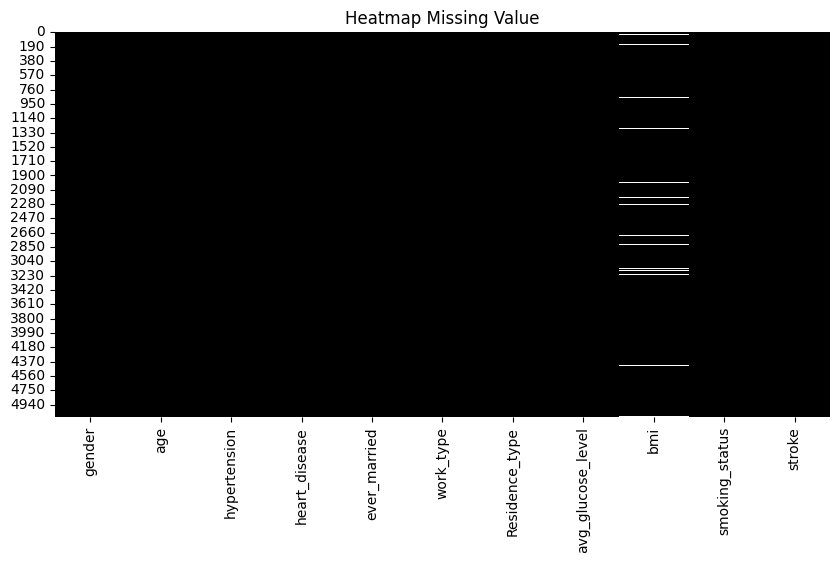

In [9]:
# Memvisualisasikan data yang hilang dalam dataset
plt.figure(figsize=(10, 5))
sns.heatmap(sp.isnull(), cbar=False, cmap="gray")
plt.title('Heatmap Missing Value')
plt.show()

In [10]:
sp.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5105    False
5106    False
5107    False
5108    False
5109    False
Length: 5110, dtype: bool

# 1. Data PreProcessing

In [11]:
# 1 = stroke, 0 = tidak stroke
stroke_counts= sp['stroke'].value_counts()
stroke_counts

stroke
0    4861
1     249
Name: count, dtype: int64

In [12]:
# Memvisualisasikan distribusi data dan mengecek korelasi
target = ['stroke']
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = [i for i in sp.columns if i not in (target + cat_cols)]


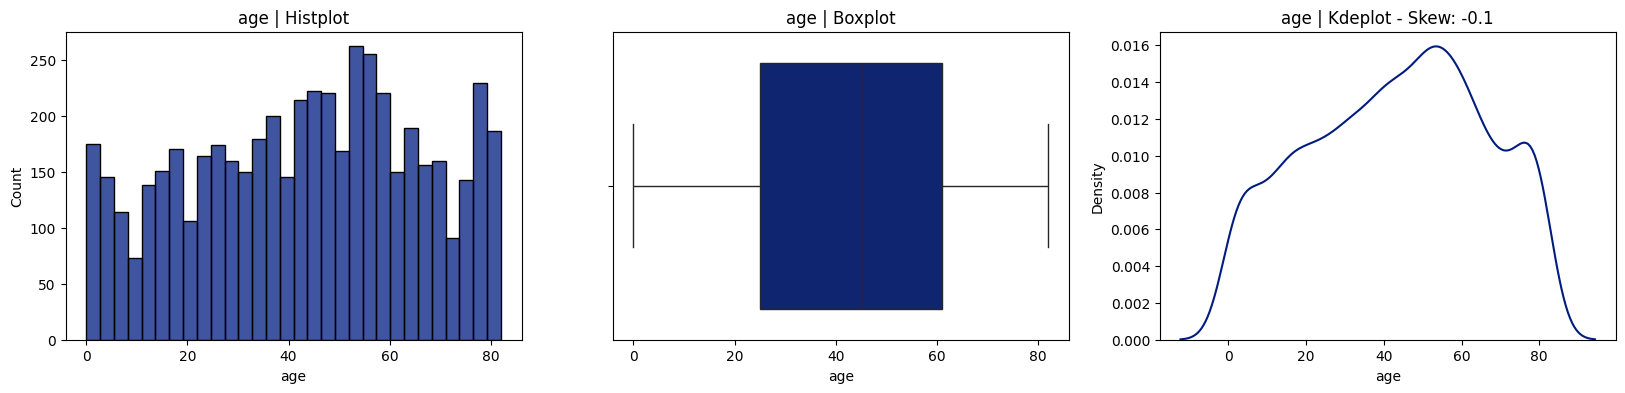

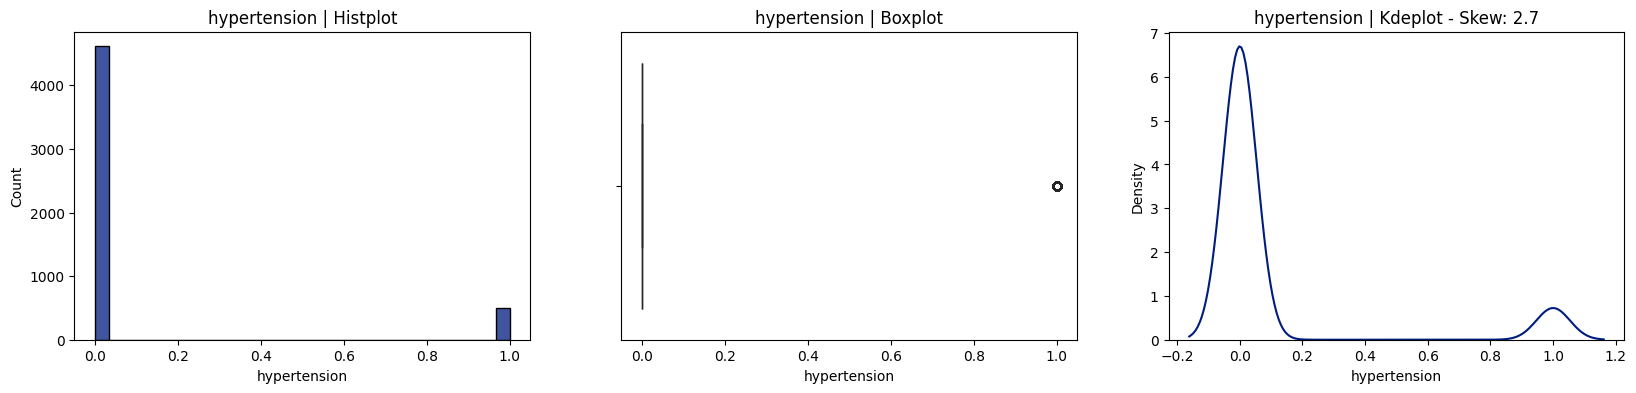

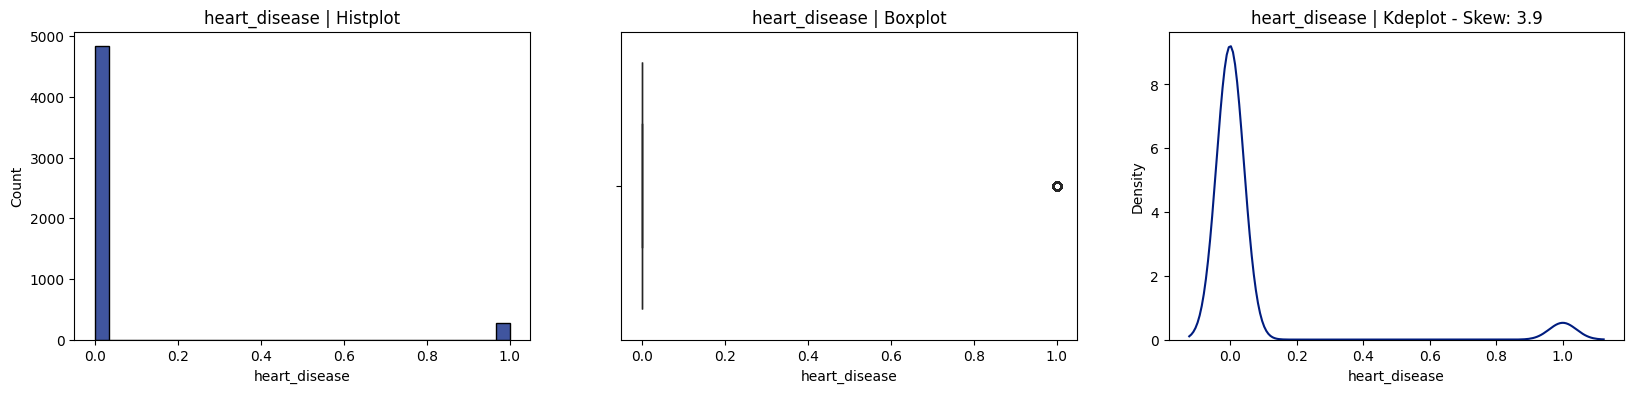

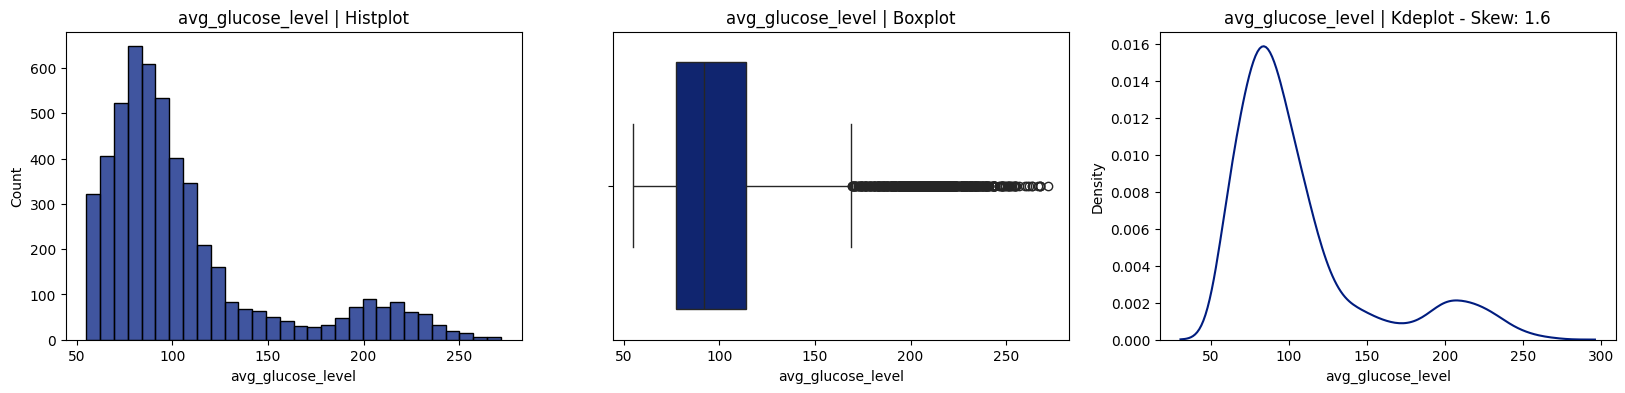

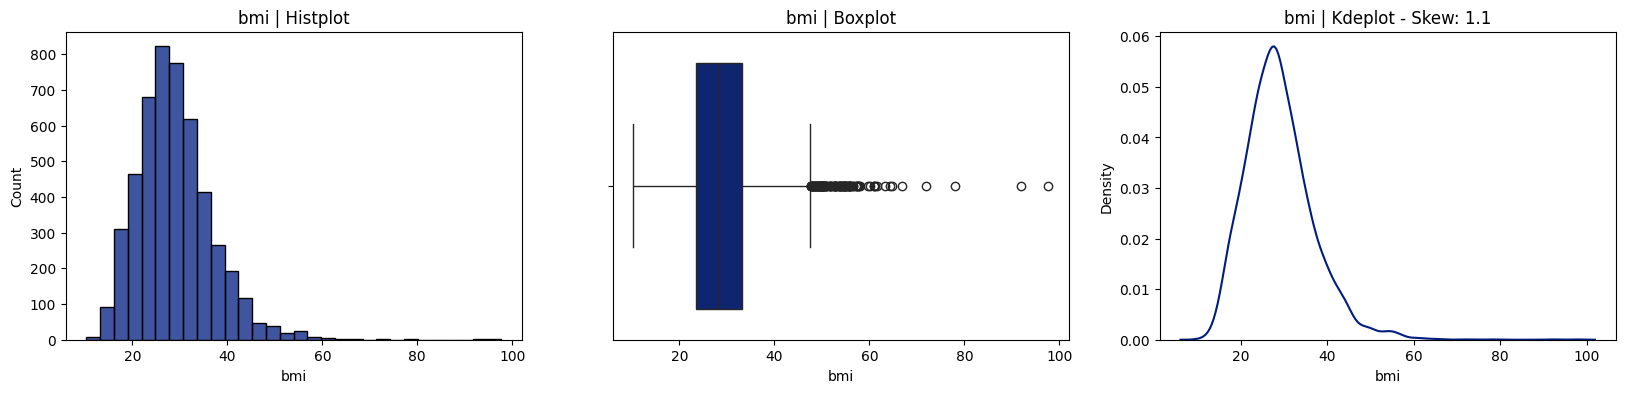

In [13]:
for i in sp[num_cols].columns:
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    sns.histplot(x=sp[i], ax=ax[0], bins=30)
    sns.boxplot(x=sp[i], ax=ax[1])
    sns.kdeplot(sp[i], ax=ax[2])
    skew_val = round(sp[i].skew(), 1)
    ax[0].set_title(i + " | Histplot")
    ax[1].set_title(i + " | Boxplot")
    ax[2].set_title(i + " | Kdeplot - Skew: " + str(skew_val))
    plt.show()

# Berdasarkan Distribusi data pada tabel numerik diatas, menunjukkan :
* Usia (Age): Histogram menunjukkan bahwa sebagian besar individu berada dalam rentang usia 40-60 tahun. Boxplot menunjukkan **median** usia sekitar 50 tahun dengan beberapa pencilan di kedua ujung. Plot KDE menunjukkan bahwa distribusi usia mirip dengan distribusi normal dengan sedikit skewness positif.
* Rata-rata Level Glukosa (Avg_glucose_level): Histogram menunjukkan bahwa sebagian besar individu memiliki level glukosa rata-rata sekitar 75-125 mg/dL, yang merupakan rentang normal. Namun, ada juga sejumlah individu dengan level glukosa yang jauh lebih tinggi, mencapai hingga 200 mg/dL. Boxplot menunjukkan **median** sekitar 100 mg/dL dengan beberapa pencilan di ujung kanan. Plot KDE menunjukkan bahwa distribusi level glukosa memiliki skewness positif yang kuat.
* Indeks Massa Tubuh (BMI): Histogram menunjukkan bahwa sebagian besar individu memiliki BMI dalam rentang 20-30, yang dianggap normal hingga overweight. Boxplot menunjukkan median BMI sekitar 25 dengan beberapa pencilan di ujung kanan. Plot KDE menunjukkan bahwa distribusi BMI memiliki skewness positif.

# Matriks Korelasi

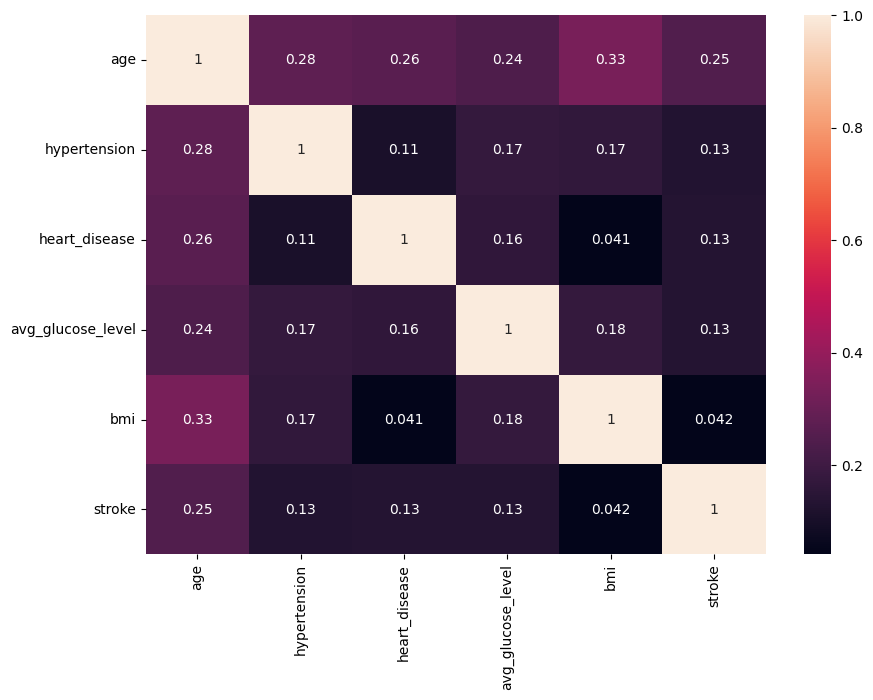

In [14]:
plt.figure(figsize=(10, 7))
sns.heatmap(sp[num_cols + target].corr().abs(), annot=True)

plt.show()

Usia (Age): Korelasi antara usia dengan variabel lainnya adalah sebagai berikut:
* Korelasi positif yang lemah dengan hipertensi (0.28).
* Korelasi positif yang lemah dengan penyakit jantung (0.26).
* Korelasi positif yang lemah dengan rata-rata kadar glukosa (0.24).
* Korelasi negatif yang kuat dengan BMI (-0.33).

Hipertensi (Hypertension): Korelasi antara hipertensi dengan variabel lainnya adalah sebagai berikut:
* Korelasi positif yang lemah dengan usia (0.28).

Penyakit Jantung (Heart Disease): Korelasi antara penyakit jantung dengan variabel lainnya adalah sebagai berikut:
* Korelasi positif yang lemah dengan usia (0.26).
* Korelasi positif yang sangat lemah dengan hipertensi (0.11).

Rata-rata Kadar Glukosa (Average Glucose Level): Korelasi antara rata-rata kadar glukosa dengan variabel lainnya adalah sebagai berikut:
* Korelasi positif yang lemah dengan usia (0.24).
* Korelasi negatif yang sangat lemah dengan hipertensi (-0.04).
* Korelasi negatif yang sangat lemah dengan penyakit jantung (-0.04).
* Korelasi positif yang kuat dengan BMI (1).

BMI: Korelasi antara BMI dengan variabel lainnya adalah sebagai berikut:
* Korelasi negatif yang kuat dengan usia (-0.33).
* Korelasi negatif yang lemah dengan hipertensi (-0.17).
* Korelasi negatif yang sangat lemah dengan penyakit jantung (-0.02).
* Korelasi negatif yang lemah dengan rata-rata kadar glukosa (-0.18).

# 2. Data Exploration / Exploratory Data Analysis (EDA)

* Visual Fitur Target

<Axes: ylabel='count'>

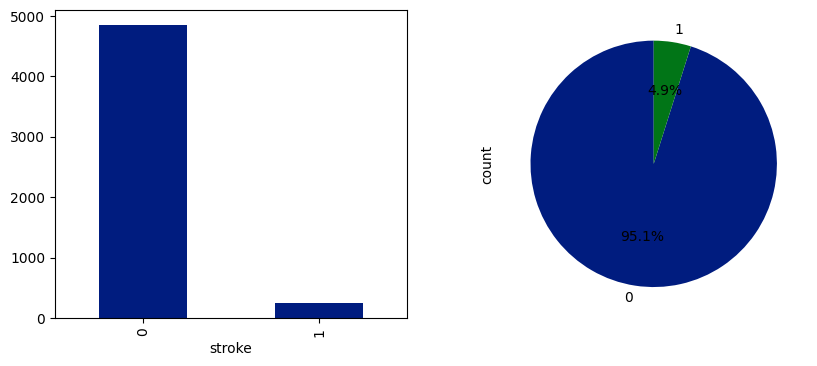

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
sp['stroke'].value_counts().plot(kind='bar', ax=axs[0])

sp['stroke'].value_counts().plot.pie(autopct='%1.1f%%', startangle =90, ax=axs[1])

*   Target dari variabel Stroke memiliki 2 value, yaitu Yes and No
*   95.1% dari hasilnya adalah No, dan 4.9% adalah Yes
*   Terlihat bahwa jumlah antara Yes dan No pada dataset tidak seimbang (imbalanced), sehingga perlu dihandle sebelum masuk ke train model

In [16]:
# Menghitung persentase pasien yang memiliki dan tidak memiliki stroke dalam dataset
countNoDisease = len(sp[sp.stroke == 0])
countHaveDisease = len(sp[sp.stroke == 1])
print("Percentage of Patients Haven't Heart Failure: {:.2f}%".format((countNoDisease / (len(sp.stroke))*100)))
print("Percentage of Patients Have Heart Failure: {:.2f}%".format((countHaveDisease / (len(sp.stroke))*100)))

Percentage of Patients Haven't Heart Failure: 95.13%
Percentage of Patients Have Heart Failure: 4.87%


* Exploring the data

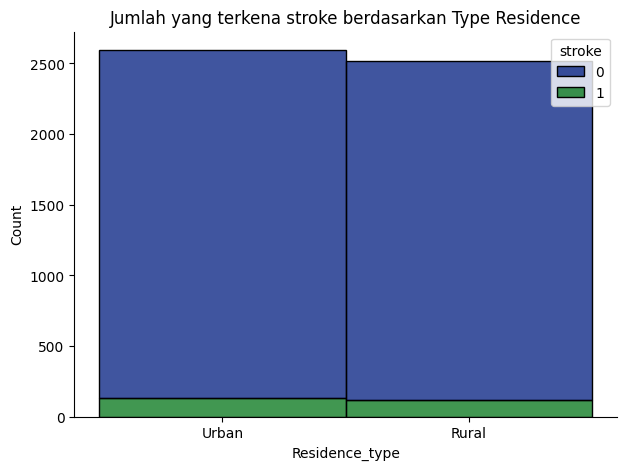

In [17]:
# Penduduk dimana berapa yang lebih sering stoke?

plt.figure(figsize=(7, 5))
sns.histplot(data=sp, x="Residence_type", hue="stroke", multiple="stack")
plt.title("Jumlah yang terkena stroke berdasarkan Type Residence")
sns.despine(top=True, right=True)
plt.show()

Jumlah individu yang tidak mengalami stroke lebih banyak dibandingkan yang mengalami stroke. Urban (Perkotaan) maupun Rural (Pedesaan)

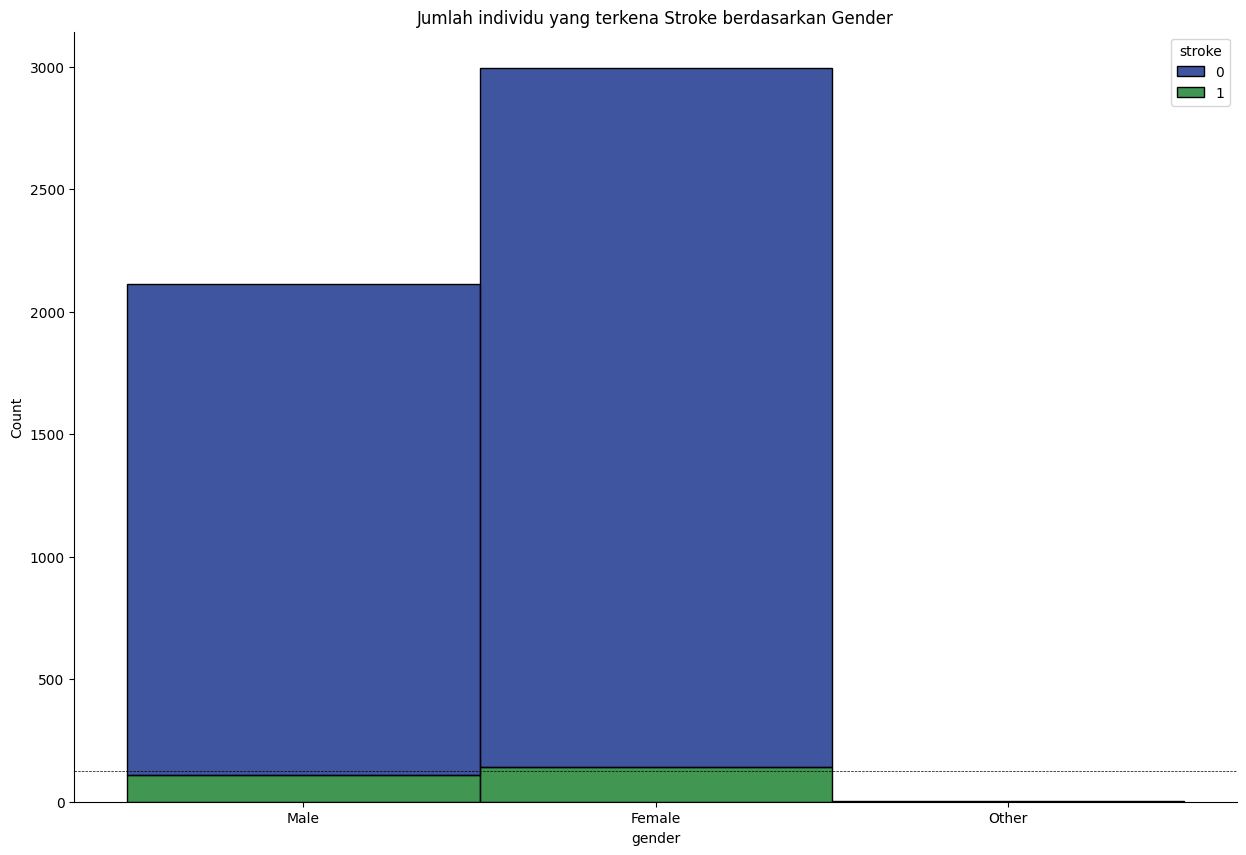

In [18]:
# Jumlah yang terkena stroke berdasarkan gender

plt.figure(figsize=(15, 10))
sns.histplot(data=sp, x="gender", hue="stroke", multiple="stack")
plt.title("Jumlah individu yang terkena Stroke berdasarkan Gender")
plt.axhline(y=125, color='black', linestyle='--', linewidth=0.5)
sns.despine(top=True, right=True)
plt.show()

Dari diagram tersebut, tampak bahwa jumlah individu perempuan yang mengalami stroke lebih banyak dibandingkan laki-laki.

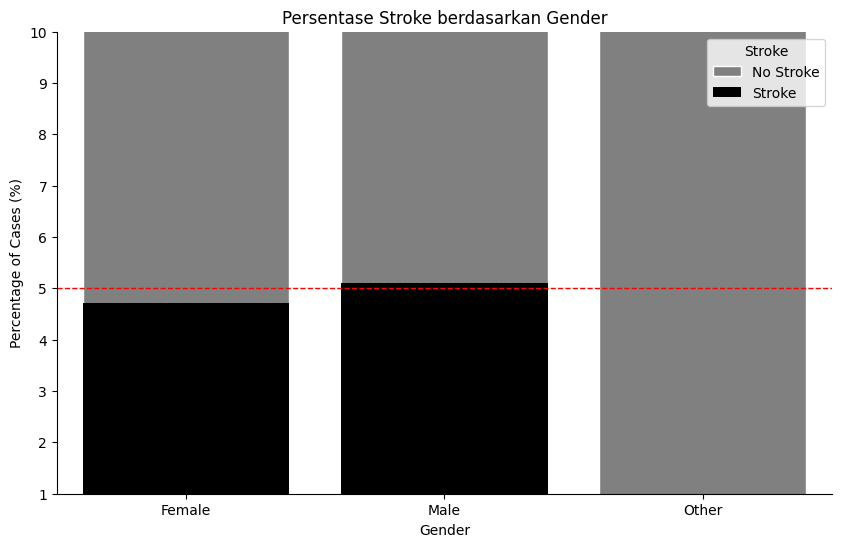

In [19]:
# Menghitung jumlah kasus stroke untuk setiap kategori "male" dan "female"
stroke_counts = sp.groupby(['gender', 'stroke']).size().unstack()

# Menghitung persentase relatif untuk setiap kategori "male" dan "female"
stroke_percentages = (stroke_counts.div(stroke_counts.sum(axis=1), axis=0) * 100).round(2)

# Plotting
plt.figure(figsize=(10, 6))

# Plot bar untuk "No Stroke"
sns.barplot(data=stroke_percentages.reset_index(), x='gender', y=0, color='grey', label='No Stroke', edgecolor='white')

# Plot bar untuk "Stroke"
sns.barplot(data=stroke_percentages.reset_index(), x='gender', y=1, color='black', label='Stroke')

plt.xlabel("Gender")
plt.ylabel("Percentage of Cases (%)")
plt.title("Persentase Stroke berdasarkan Gender")
plt.legend(title="Stroke")

# zoom ke 10%
plt.ylim(1, 10)
plt.axhline(y=5, color='red', linestyle='--', linewidth=1)
sns.despine(top=True, right=True)

Dari diagram diatas, bahwa persentase kasus stroke pada kategori Female dan Male hampir sama, sedangkan untuk kategori Other tidak terlihat adanya kasus stroke.

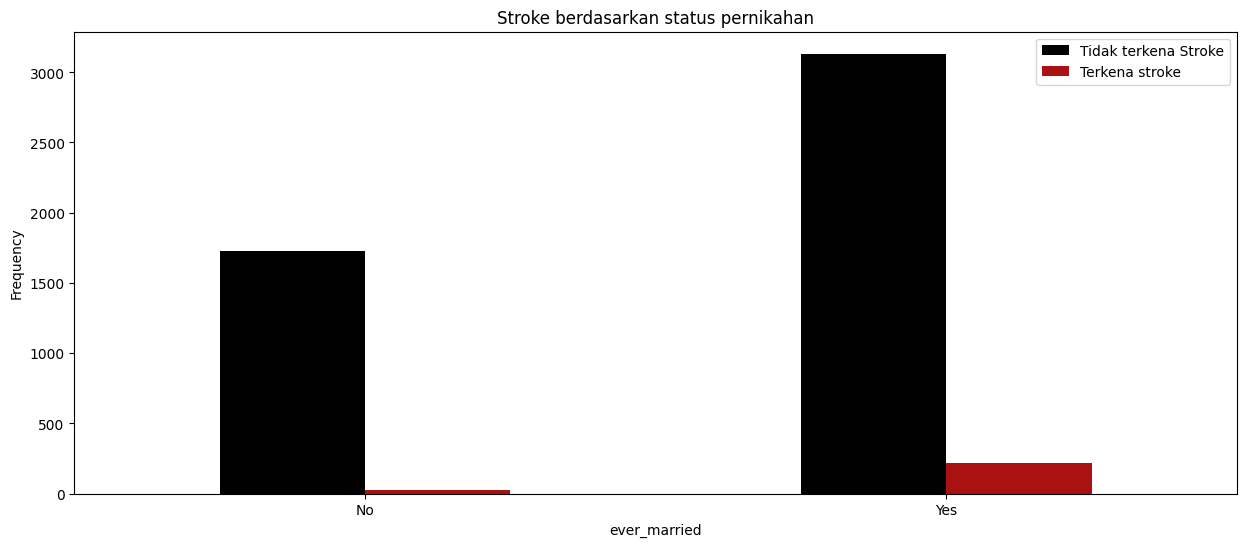

In [20]:
pd.crosstab(sp.ever_married, sp.stroke).plot(kind="bar",figsize=(15,6),color=['black','#AA1111' ])
plt.title('Stroke berdasarkan status pernikahan')
plt.xticks(rotation=0)
plt.legend(["Tidak terkena Stroke", "Terkena stroke"])
plt.ylabel('Frequency')
plt.show()

Dari diagram tersebut, tampak bahwa jumlah individu yang pernah menikah dan mengalami stroke lebih banyak dibandingkan dengan individu yang belum pernah menikah. Yes (pernah menikah) dan No (belum pernah menikah)

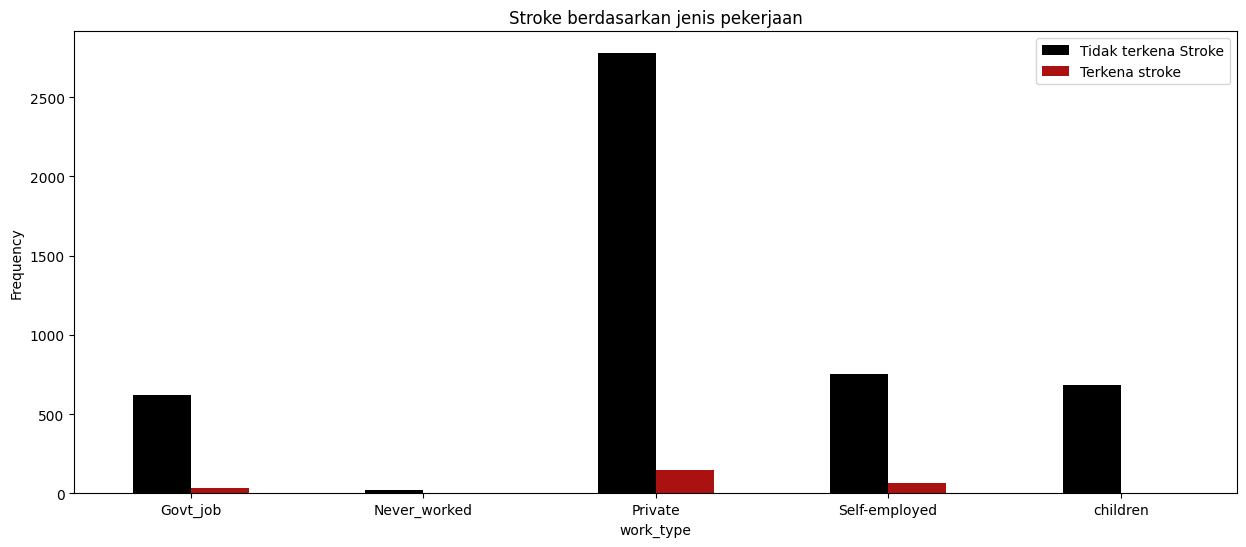

In [21]:
pd.crosstab(sp.work_type, sp.stroke).plot(kind="bar",figsize=(15,6),color=['black','#AA1111' ])
plt.title('Stroke berdasarkan jenis pekerjaan')
plt.xticks(rotation=0)
plt.legend(["Tidak terkena Stroke", "Terkena stroke"])
plt.ylabel('Frequency')
plt.show()

Dari diagram tersebut, tampak bahwa jumlah kasus stroke paling tinggi terjadi pada individu dengan jenis pekerjaan ‘Private work, type’. Sementara itu, individu yang ‘Never worked’ dan ‘children’ memiliki jumlah kasus stroke terendah.

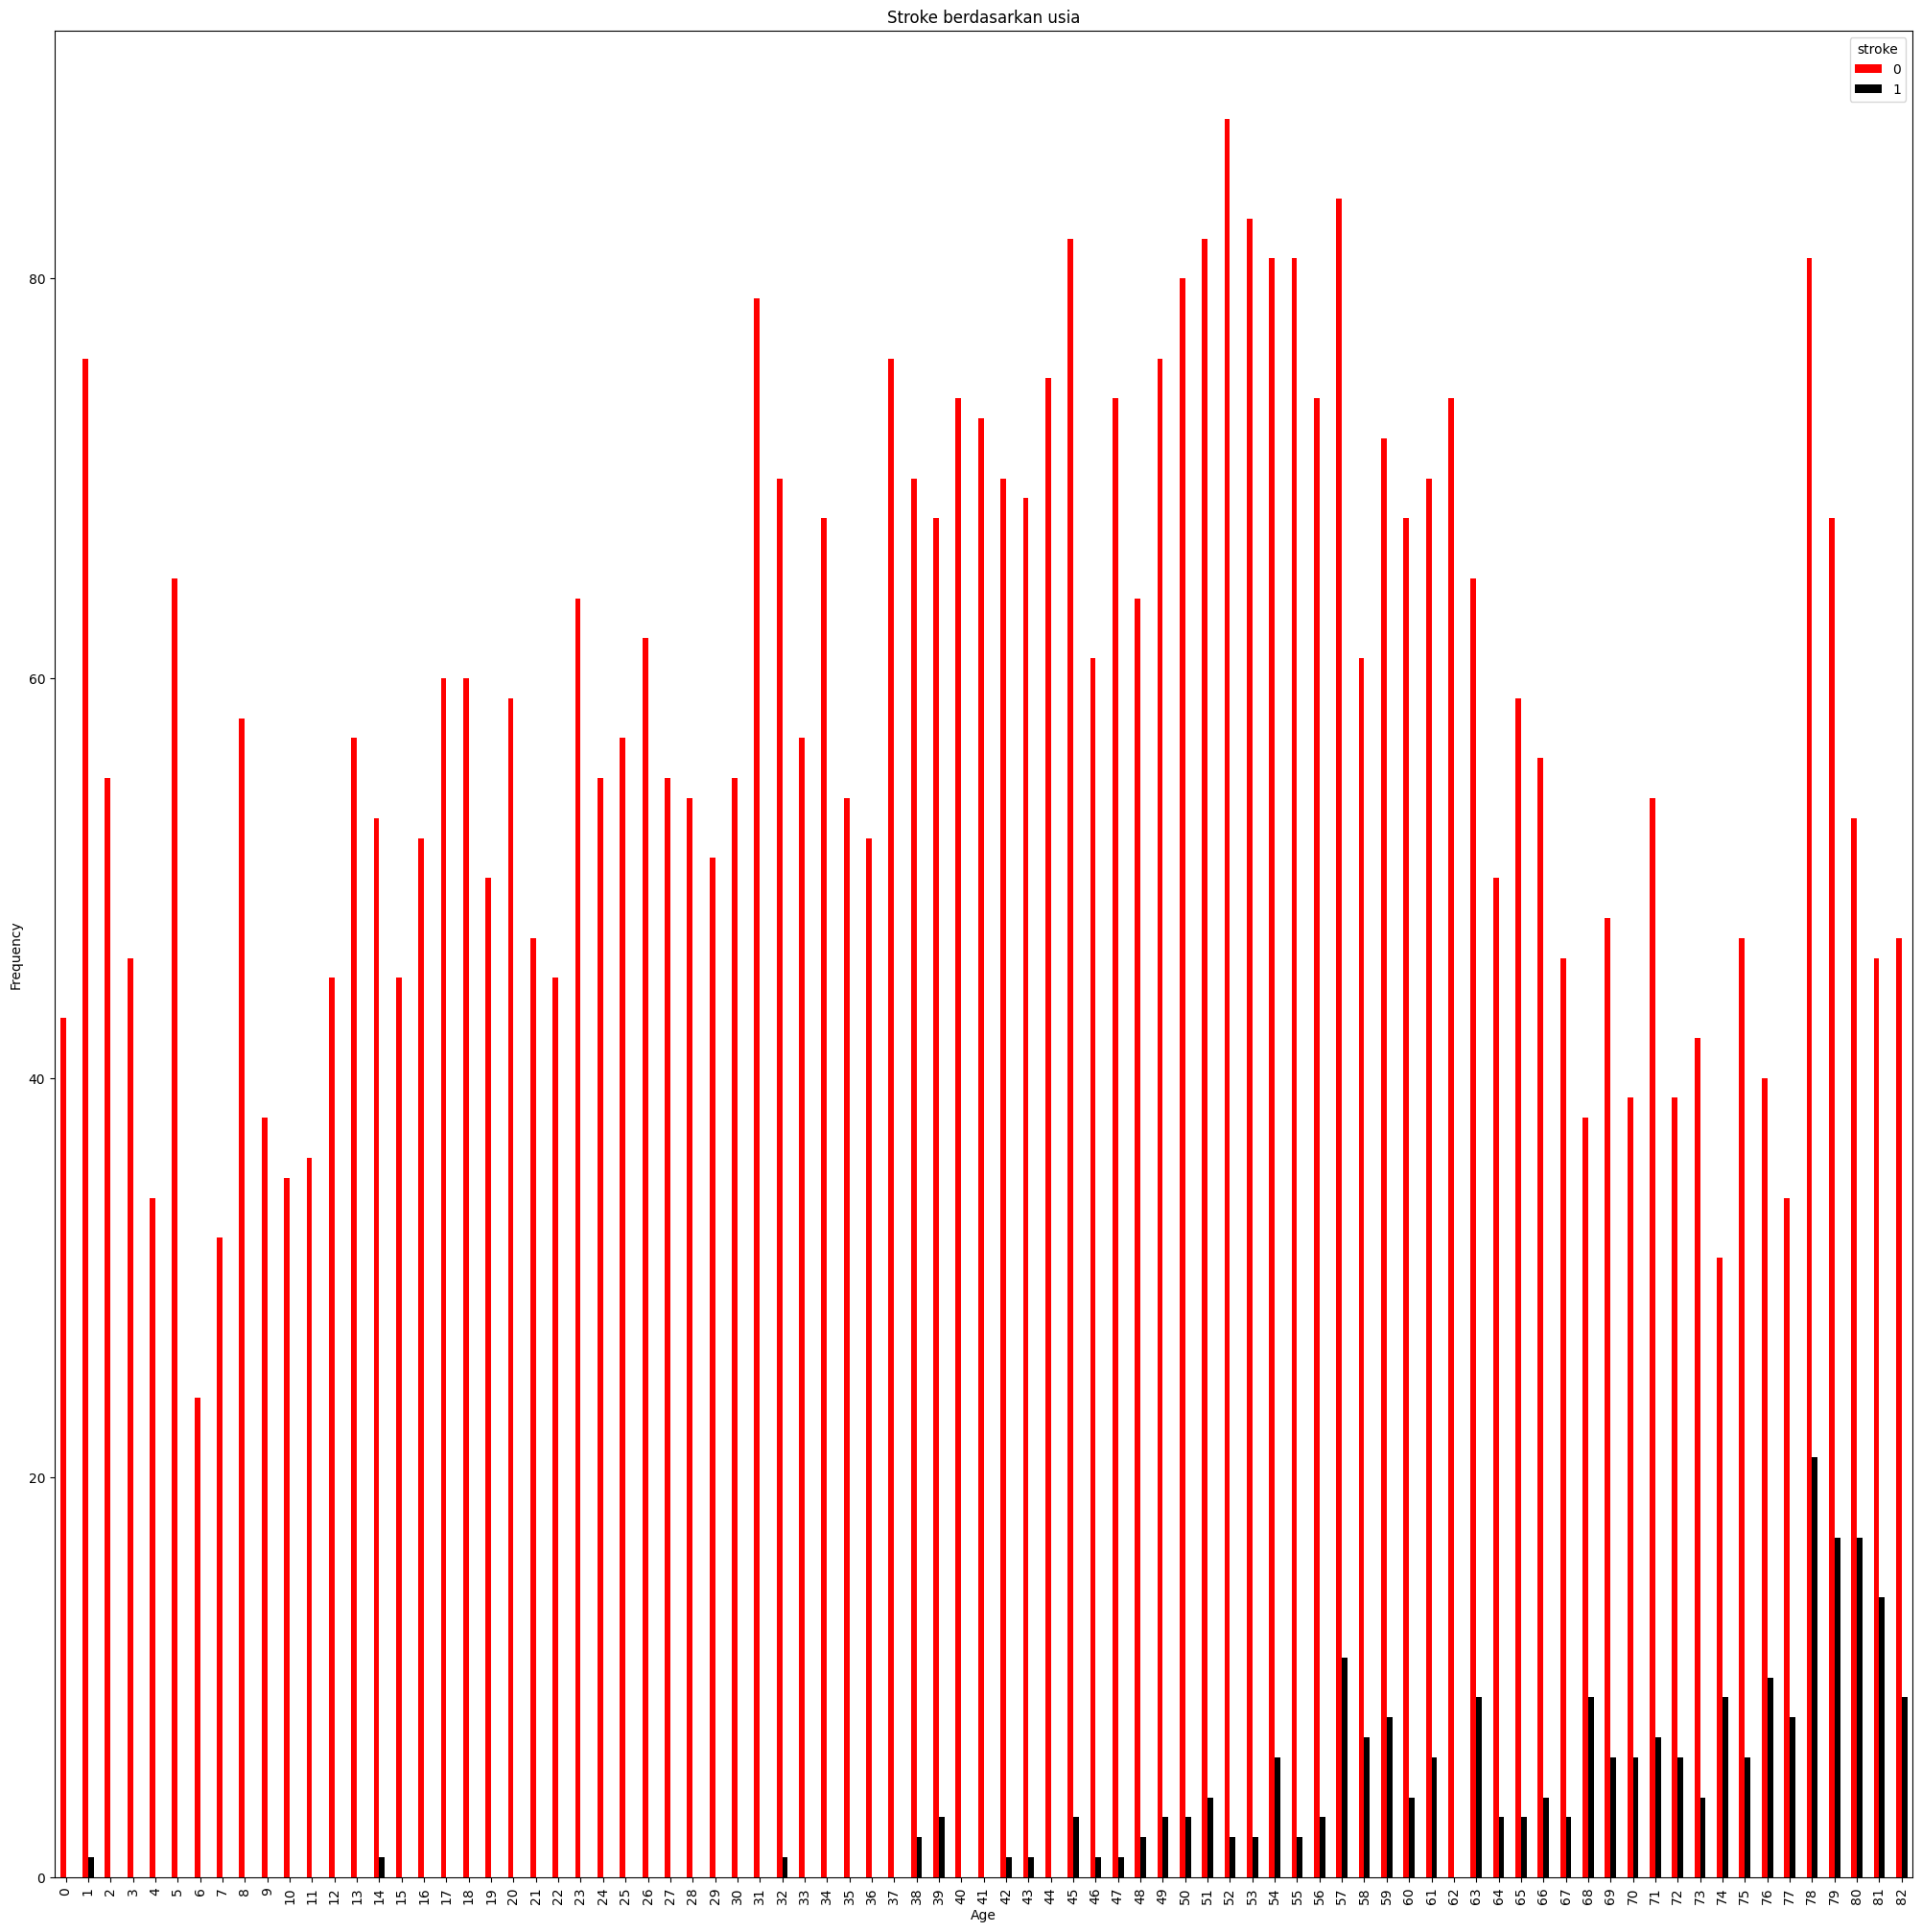

In [22]:
pd.crosstab(sp.age, sp.stroke).plot(kind="bar",figsize=(25,25), color=['red','black' ])
plt.title('Stroke berdasarkan usia')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Jumlah Individu yang mengalami stroke terjadi pada rentang Usia >= 45 tahun. Resiko Stroke makin tinggi pada usia 45 tahun keatas.

Text(0, 0.5, 'Frequency')

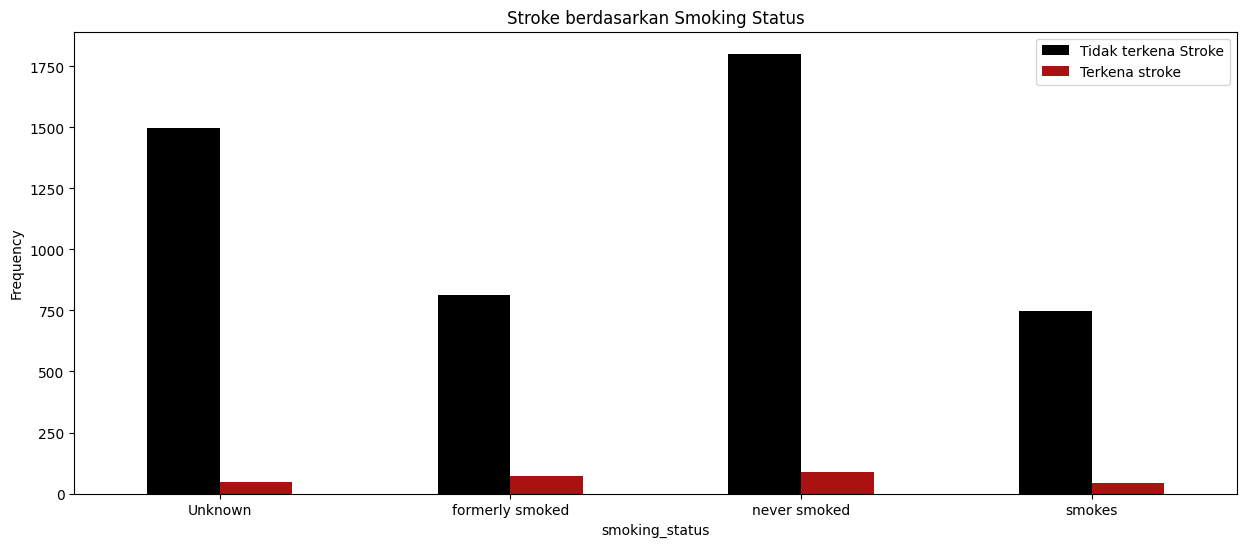

In [23]:
pd.crosstab(sp.smoking_status, sp.stroke).plot(kind="bar",figsize=(15,6),color=['black','#AA1111' ])
plt.title('Stroke berdasarkan Smoking Status')
plt.xticks(rotation=0)
plt.legend(["Tidak terkena Stroke", "Terkena stroke"])
plt.ylabel('Frequency')

Individu yang 'never smoked' memiliki kemungkinan lebih besar untuk tidak terkena dan terkena stroke.
Dari diagram tersebut, menunjukkan bahwa jumlah kasus stroke paling tinggi terjadi pada individu dengan status merokok ‘Unknown’ dan ‘never smoked’. Sementara itu, individu yang ‘smokes’ memiliki jumlah kasus stroke terendah.

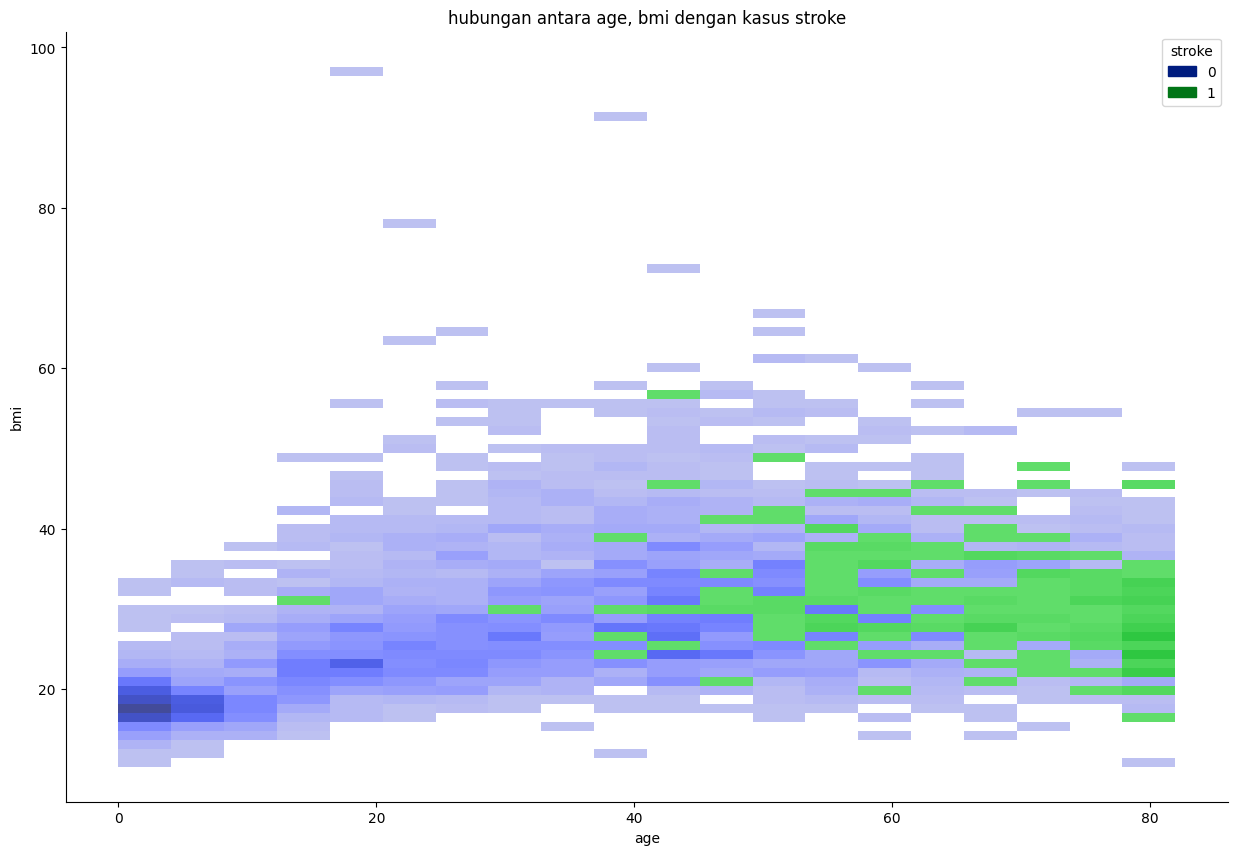

In [24]:
# Visualisasi hubungan antara age, bmi dan kasus stroke

plt.figure(figsize=(15, 10))
sns.histplot(data=sp, x="age", y="bmi", hue="stroke", multiple="stack")
plt.title("hubungan antara age, bmi dengan kasus stroke")
sns.despine(top=True, right=True)

plt.show()

* **bmi 18,5 - 24,9 berarti berat badan normal. Antara 25-29,9 berarti berat badan berlebih (overweight)**. Dari data diatas terbukti bahwa bmi diatas 24,9 mengalami stroke lebih banyak
* Berdasarkan data diatas peluang terkena stroke semakin tinggi jika usia makin tinggi (pada usia kurang atau  = 45) dan bmi tinggi (pada usia kurang atau = 20)

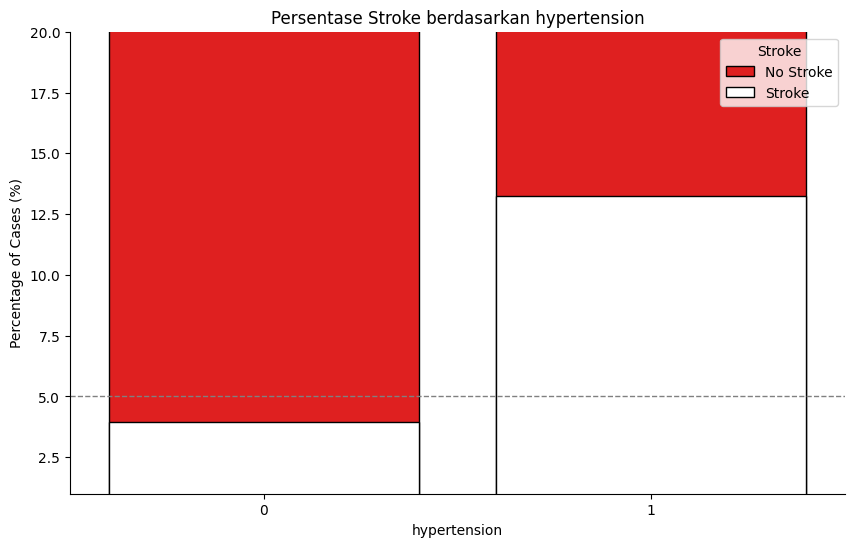

In [25]:
stroke_counts = sp.groupby(['hypertension', 'stroke']).size().unstack()

stroke_percentages = (stroke_counts.div(stroke_counts.sum(axis=1), axis=0)*100).round(2)

plt.figure(figsize=(10, 6))

sns.barplot(data=stroke_percentages.reset_index(), x='hypertension', y=0, color='red', label='No Stroke', edgecolor='black')

sns.barplot(data=stroke_percentages.reset_index(), x='hypertension', y=1, color='white', label='Stroke', edgecolor='black')

plt.xlabel("hypertension")
plt.ylabel("Percentage of Cases (%)")
plt.title("Persentase Stroke berdasarkan hypertension")
plt.legend(title="Stroke")

# zoom ke 20%
plt.ylim(1, 20)
plt.axhline(y=5, color='gray', linestyle='--', linewidth=1)
sns.despine(top=True, right=True)

Pada Individu yang terkena Hipertensi berpeluang lebih besar terkena stroke.

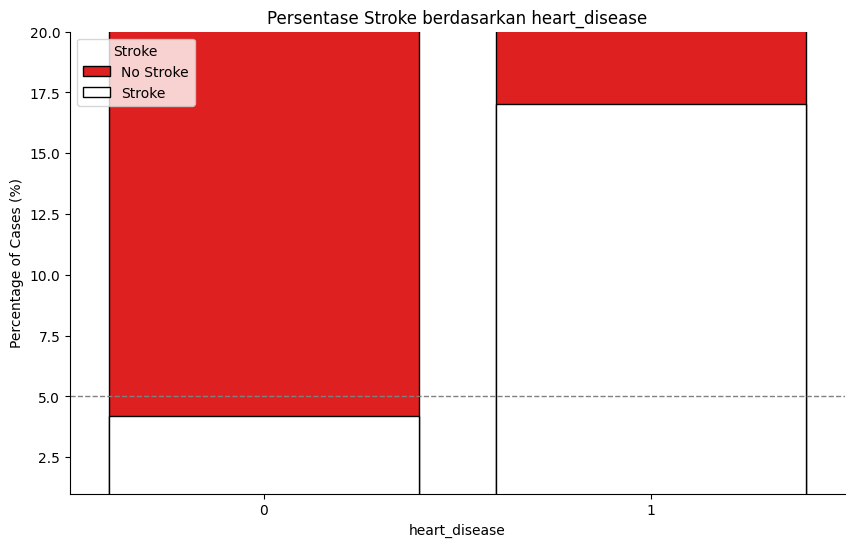

In [26]:
stroke_counts = sp.groupby(['heart_disease', 'stroke']).size().unstack()

stroke_percentages = (stroke_counts.div(stroke_counts.sum(axis=1), axis=0) * 100).round(2)

plt.figure(figsize=(10, 6))

sns.barplot(data=stroke_percentages.reset_index(), x='heart_disease', y=0, color='red', label='No Stroke', edgecolor='black')

sns.barplot(data=stroke_percentages.reset_index(), x='heart_disease', y=1, color='white', label='Stroke', edgecolor='black')

plt.xlabel("heart_disease")
plt.ylabel("Percentage of Cases (%)")
plt.title("Persentase Stroke berdasarkan heart_disease")
plt.legend(title="Stroke")

# zoom ke 20%
plt.ylim(1, 20)
plt.axhline(y=5, color='gray', linestyle='--', linewidth=1)
sns.despine(top=True, right=True)

Bagi Individu yang terkena heart_disease berpeluang lebih besar terkena stroke.

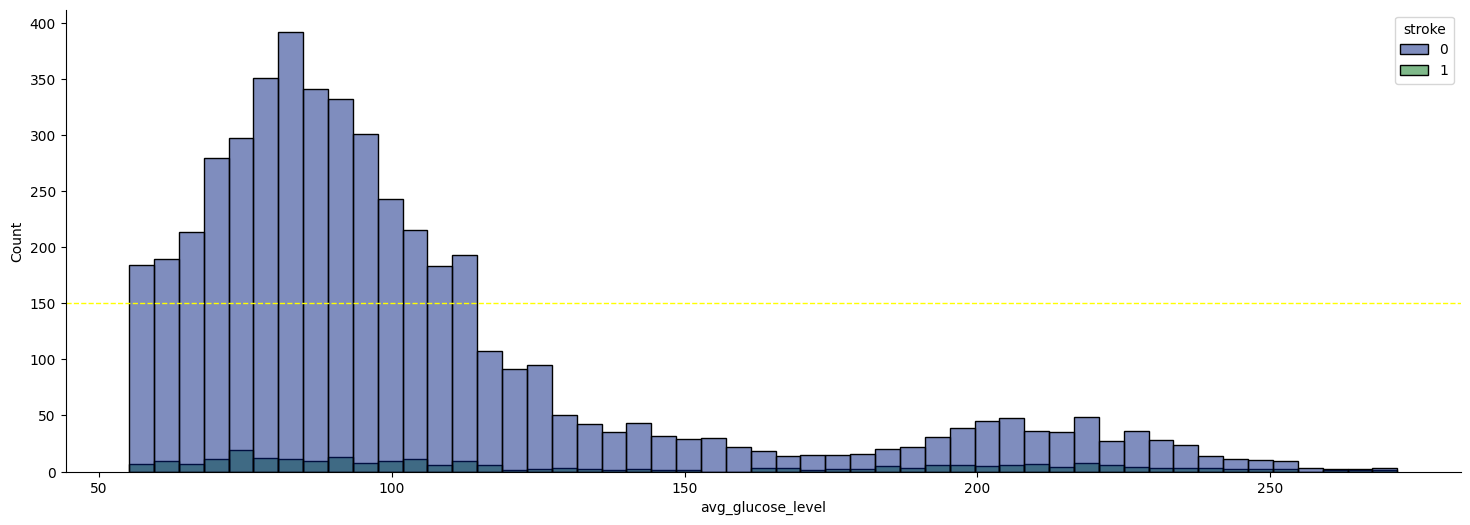

In [27]:
plt.figure(figsize=(18, 6))
sns.histplot(data=sp, x="avg_glucose_level", hue="stroke")
plt.axhline(y=150, color='yellow', linestyle='--', linewidth=1)
sns.despine(top=True, right=True)

Kadar gula yang Normal adalah kurang dari 70–140 mg/dl.
Kadar gula yang terlalu Rendah maupun gula yang terlalu Tinggi meningkatkan peluang terkena stroke.

# Kesimpulan Analisis EDA/Exploratory Data Analysis
* Variabel Stroke: Variabel target memiliki dua nilai, yaitu ‘Yes’ dan ‘No’. Mayoritas (95,1%) dari data menunjukkan ‘No’, sementara hanya 4,9% yang menunjukkan ‘Yes’. Data ini tidak seimbang dan perlu diatasi sebelum digunakan untuk melatih model.
* Gagal Jantung: Mayoritas individu (95,13%) belum pernah mengalami gagal jantung, sementara 4,87% pernah mengalami gagal jantung.
* Lokasi dan Jenis Kelamin: Individu yang tidak mengalami stroke lebih banyak dibandingkan yang mengalami stroke, baik di area perkotaan maupun pedesaan. Jumlah individu perempuan yang mengalami stroke lebih banyak dibandingkan laki-laki, namun persentase kasus stroke antara perempuan dan laki-laki hampir sama.
* Status Pernikahan dan Pekerjaan: Individu yang pernah menikah memiliki jumlah kasus stroke yang lebih tinggi dibandingkan dengan individu yang belum pernah menikah. Individu dengan jenis pekerjaan ‘Private work, type’ memiliki jumlah kasus stroke tertinggi, sementara individu yang ‘Never worked’ dan ‘children’ memiliki jumlah kasus stroke terendah.
* Usia dan BMI: Risiko stroke meningkat pada usia 45 tahun ke atas. Individu dengan BMI di atas 24,9 memiliki risiko stroke yang lebih tinggi.
* Merokok: Individu yang ‘never smoked’ memiliki kemungkinan lebih besar untuk tidak terkena stroke. Namun, jumlah kasus stroke paling tinggi terjadi pada individu dengan status merokok ‘Unknown’ dan ‘never smoked’.
* Hipertensi dan Penyakit Jantung: Individu yang memiliki hipertensi atau penyakit jantung memiliki peluang lebih besar untuk terkena stroke.
* Kadar Gula: Kadar gula yang normal adalah kurang dari 70–140 mg/dl. Kadar gula yang terlalu rendah atau terlalu tinggi dapat meningkatkan peluang terkena stroke.



-----------------------------------------------------------------------------------------------------------------

* Split Data

In [28]:
X = sp.drop('stroke', axis = 1)
y = sp.stroke

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [30]:
# Sebelum checking & handing outliernya saya akan convert terlebih dahulu fitur kategori LabelEncoder agar memudahkan dalam handling outlier

le = LabelEncoder()
X[cat_cols] = X[cat_cols].astype('str').apply(le.fit_transform)

In [31]:
# Mengecek jumlah dan presentase missing value pada setiap variabel yang ada dalam X_train.

mv_train = pd.DataFrame(X_train.isnull().sum(), columns=['No. of missing values'])
mv_train['% missing_values'] = (mv_train/len(X_train)).round(2)*100
mv_train

,No. of missing values,% missing_values
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,156,4.0
smoking_status,0,0.0


* Checking & Handling Outlier

In [32]:
# Menampilkan presentasi outlier pada X_train

for k, v in X_train.select_dtypes(include=['number']).items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(X_train)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column age outliers = 0.00%
Column hypertension outliers = 100.00%
Column heart_disease outliers = 100.00%
Column avg_glucose_level outliers = 12.30%
Column bmi outliers = 2.40%


* Capping

Saya menerapkan teknik ‘capping’ untuk menangani variabel dalam X_train yang memiliki outlier, dengan persentase outlier antara 3% hingga 25%.

Saya menggunakan teknik ‘trimming’ untuk menangani variabel yang memiliki outlier, dengan persentase outlier sama dengan atau kurang dari 3%.

In [33]:
# Function untuk membuat histogram dan boxplot.
# Function untuk mengambil dataframe dan variabel yang menarik sebagai argumen.

def diagnostic_plots(sp, variable):
    
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(sp[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=sp[variable])
    plt.title('Boxplot')

    plt.show()

In [34]:
# Saya menerapkan teknik ‘capping’ untuk menangani variabel dalam X_train yang memiliki outlier, 
# khususnya pada variabel ‘avg_glucose_level’ yang memiliki persentase outlier sebesar 12.30%, 
# yang berada dalam rentang 3% hingga 25%.


!pip install feature-engine

# Membuat capper

windsoriser = Winsorizer(capping_method='iqr', 
                          tail='both', # cap kiri, kanan or kedua ekor.
                          fold=1.5,
                          variables=['avg_glucose_level'])

windsoriser.fit(X_train)

X_train_t = windsoriser.transform(X_train)

In [35]:
# Memberikan gambaran tentang batas bawah dan atas yang telah ditentukan untuk setiap variabel dalam dataset Anda untuk menangani outlier.
print('Left Tail Caps  : ', windsoriser.left_tail_caps_)

print('Right Tail Caps : ', windsoriser.right_tail_caps_)

Left Tail Caps  :  {'avg_glucose_level': 20.910000000000004}
Right Tail Caps :  {'avg_glucose_level': 170.98999999999998}


In [36]:
print('avg_glucose_level - Before Capping')
print(X_train.describe())
print('')
print('avg_glucose_level - After Capping')
print(X_train_t.describe())

avg_glucose_level - Before Capping
               age  hypertension  heart_disease  avg_glucose_level  \
count  4088.000000   4088.000000    4088.000000        4088.000000   
mean     43.293542      0.093933       0.052838         106.453672   
std      22.555761      0.291772       0.223736          45.629802   
min       0.000000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.190000   
50%      45.000000      0.000000       0.000000          91.895000   
75%      61.000000      0.000000       0.000000         114.710000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi  
count  3932.000000  
mean     28.952314  
std       7.910890  
min      10.300000  
25%      23.600000  
50%      28.000000  
75%      33.100000  
max      97.600000  

avg_glucose_level - After Capping
               age  hypertension  heart_disease  avg_glucose_level  \
count  4088.000000   4088.000000    4088

avg_glucose_level - Before Capping


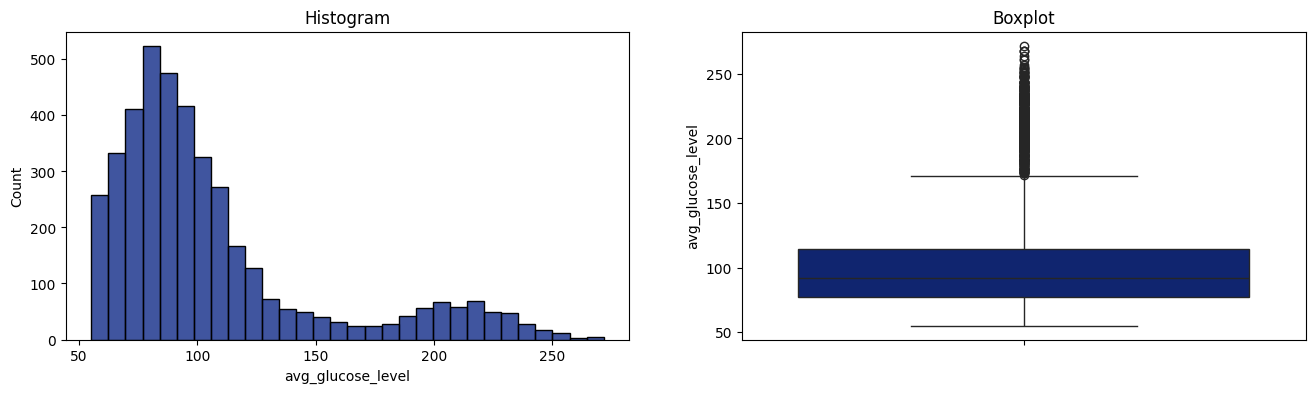

avg_glucose_level - After Capping


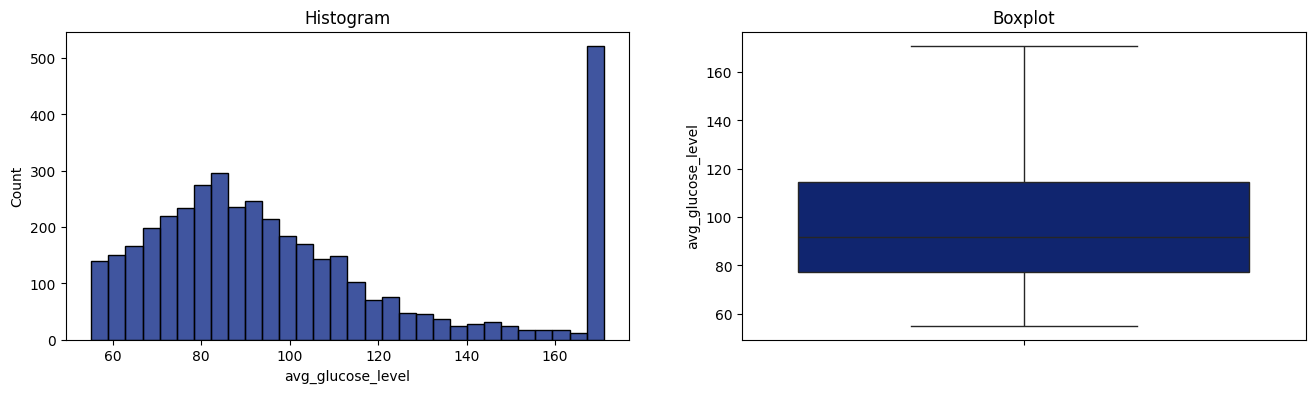

In [37]:
print('avg_glucose_level - Before Capping')
diagnostic_plots(X_train, 'avg_glucose_level')
print('avg_glucose_level - After Capping')
diagnostic_plots(X_train_t, 'avg_glucose_level')

“Karena tidak ada variabel dalam X_Train yang memiliki persentase outlier sama dengan atau kurang dari 3%, saya memutuskan untuk tidak melakukan proses ‘trimming’. Ini berlaku khusus untuk variabel yang akan digunakan.”

* Limit (Membatasi)

In [38]:
# Function untuk menemukan batas atas dan bawah untuk variabel dengan distribusi miring.
# Hitung batas di luar mana outlier berada untuk distribusi yang miring.
# Jarak yang dilewatkan sebagai argumen, memberi opsi untuk mengestimasi 1,5 kali atau 3 kali IQR untuk menghitung batasannya.

def find_skewed_boundaries(sp, variable, distance):
    IQR = sp[variable].quantile(0.75) - sp[variable].quantile(0.25)

    lower_bound = sp[variable].quantile(0.25) - (IQR * distance)
    upper_bound = sp[variable].quantile(0.75) + (IQR * distance)

    return upper_bound, lower_bound

In [39]:
# Limits untuk `age`
age_up_limit, age_low_limit = find_skewed_boundaries(X_train, 'age', 1.5)
age_up_limit, age_low_limit

# Limits untuk `avg_glucose_level`
avg_glucose_level_up_limit, avg_glucose_level_low_limit = find_skewed_boundaries(X_train, 'avg_glucose_level', 1.5)
avg_glucose_level_up_limit, avg_glucose_level_low_limit

print('age_up_limit : ', age_up_limit)
print('age_low_limit : ', age_low_limit, '\n')
print('avg_glucose_level_limit : ', avg_glucose_level_up_limit)
print('avg_glucose_level_limit : ', avg_glucose_level_low_limit, '\n')

age_up_limit :  115.0
age_low_limit :  -29.0 

avg_glucose_level_limit :  170.98999999999998
avg_glucose_level_limit :  20.910000000000004 



In [40]:
index_drop_train = X_train.index[X_train['age'] > age_up_limit]
X_train = X_train.drop(index_drop_train.tolist())
y_train = y_train.drop(index_drop_train.tolist())

In [41]:
index_drop_train = X_train.index[X_train['avg_glucose_level'] > avg_glucose_level_up_limit]
X_train = X_train.drop(index_drop_train.tolist())
y_train = y_train.drop(index_drop_train.tolist())

In [42]:
# Limits untuk `age`
age_up_limit, age_low_limit = find_skewed_boundaries(X_train, 'age', 1.5)
age_up_limit, age_low_limit

# Limits untuk `avg_glucose_level`
avg_glucose_level_up_limit, avg_glucose_level_low_limit = find_skewed_boundaries(X_train, 'avg_glucose_level', 1.5)
avg_glucose_level_up_limit, avg_glucose_level_low_limit

print('age_up_limit : ', age_up_limit)
print('age_low_limit : ', age_low_limit, '\n')
print('avg_glucose_level_limit : ', avg_glucose_level_up_limit)
print('avg_glucose_level_limit : ', avg_glucose_level_low_limit, '\n')

age_up_limit :  110.5
age_low_limit :  -29.5 

avg_glucose_level_limit :  148.07999999999998
avg_glucose_level_limit :  30.959999999999994 



In [43]:
index_drop_test = X_test.index[X_test['age'] > age_up_limit]
X_test = X_test.drop(index_drop_test.tolist())
y_test = y_test.drop(index_drop_test.tolist())

In [44]:
index_drop_test = X_test.index[X_test['avg_glucose_level'] > avg_glucose_level_up_limit]
X_test = X_test.drop(index_drop_test.tolist())
y_test = y_test.drop(index_drop_test.tolist())

* Handling (IMPUTATION) Missing Value

--Variabel Numerik 
* Berdasarkan matriks korelasi, tampak bahwa ‘age’, ‘hypertension’, ‘heart_disease’, dan ‘avg_glucose_level’ adalah fitur yang memiliki korelasi paling tinggi dengan variabel target (stroke). Oleh karena itu, saya memilih untuk menggunakan keempat fitur numerik ini karena mereka memiliki korelasi tertinggi dengan target.

In [45]:
# Cek jumlah dan presentase missing value pada setiap variabel yang ada dalam X_train.

mv_train = pd.DataFrame(X_train.isnull().sum(), columns=['No. of missing values'])
mv_train['% missing_values'] = (mv_train/len(X_train)).round(2)*100
mv_train

,No. of missing values,% missing_values
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
ever_married,0,0.0
work_type,0,0.0
Residence_type,0,0.0
avg_glucose_level,0,0.0
bmi,111,3.0
smoking_status,0,0.0


In [46]:
num_feature_train = X_train[num_cols].loc[:, ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']]
num_feature_test = X_test[num_cols].loc[:, ['age', 'hypertension', 'heart_disease', 'avg_glucose_level']]

X_train_num = num_feature_train
X_test_num = num_feature_test

print(X_train_num.isna().sum())
print(X_test_num.isna().sum())

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
dtype: int64
age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
dtype: int64


Tidak ditemukannya missing values pada 4 fitur numerik tersebut.

In [47]:
processed_data_train = np.concatenate([X_train_num], axis=1)
X_train = processed_data_train
X_train

array([[ 79.  ,   0.  ,   0.  , 112.64],
       [ 62.  ,   0.  ,   0.  ,  88.32],
       [ 21.  ,   0.  ,   0.  ,  59.52],
       ...,
       [ 61.  ,   1.  ,   0.  , 170.05],
       [  1.  ,   0.  ,   0.  ,  97.28],
       [ 46.  ,   0.  ,   0.  , 100.15]])

In [48]:
processed_data_test = np.concatenate([X_test_num], axis=1)
X_test = processed_data_test
X_test

array([[ 31.  ,   0.  ,   0.  ,  64.85],
       [ 40.  ,   0.  ,   0.  ,  65.29],
       [  8.  ,   0.  ,   0.  ,  74.42],
       ...,
       [ 49.  ,   1.  ,   0.  , 119.3 ],
       [ 56.  ,   0.  ,   0.  , 128.63],
       [ 78.  ,   1.  ,   1.  , 106.41]])

# 3. Model Development

* Pipeline & Parameter Tuning

In [49]:
pipe_rf = Pipeline([
('scaler', StandardScaler()),
('classifier', RandomForestClassifier())])

pipe_dt = Pipeline([
('scaler', StandardScaler()),
('classifier', DecisionTreeClassifier())])

#Random Forest
param_rf = {'scaler': [StandardScaler(),MinMaxScaler()],
            'classifier__max_depth': [10, 50, 100],
            'classifier__max_features': [2, 3],
            'classifier__min_samples_leaf': [3, 4, 5],
            'classifier__min_samples_split': [8, 10, 12],
            'classifier__n_estimators': [100, 200, 300]
            }

param_dt = {'scaler': [StandardScaler(),MinMaxScaler()],
            'classifier__min_samples_split': [50, 100, 200],
            'classifier__min_samples_leaf': [3, 4, 5],
            'classifier__max_depth': [8, 10, 12],
            'classifier__max_features': [2, 3]
            }

Train W/O Tunning
* Random Forest

In [50]:
pipe_rf.fit(X_train, y_train)
print('Training Score: ',round(pipe_rf.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_rf.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.9558


In [51]:
y_rf_pred = pipe_rf.predict(X_test)

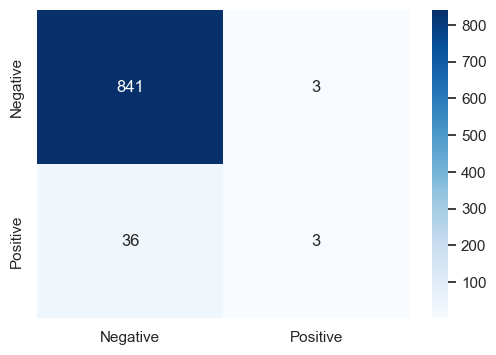

In [52]:
cf_matrix_rf = confusion_matrix(y_test, y_rf_pred)
sns.set(rc={'figure.figsize':(6,4)})

ax = sns.heatmap(cf_matrix_rf, annot = True,cmap='Blues', fmt='g')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.show()

Pada hasil confussion matrix terlihat bahwa:
*   Pada kelas 0 (No) untuk prediksi Stroke pada data test terprediksi benar sebanyak 841 dan 3 terprediksi salah sebagai 1 (Yes)
*   Pada kelas 1 (Yes) untuk prediksi Stroke pada data test terprediksi benar sebanyak 36 dan 3 terprediksi salah sebagai 0 (No)

In [53]:
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       844
           1       0.50      0.08      0.13        39

    accuracy                           0.96       883
   macro avg       0.73      0.54      0.56       883
weighted avg       0.94      0.96      0.94       883



* Decision Tree

In [54]:
pipe_dt.fit(X_train, y_train)
print('Training Score: ',round(pipe_dt.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_dt.score(X_test, y_test),4))

Training Score:  1.0
Testing Score:  0.9422


In [55]:
y_dt_pred = pipe_dt.predict(X_test)

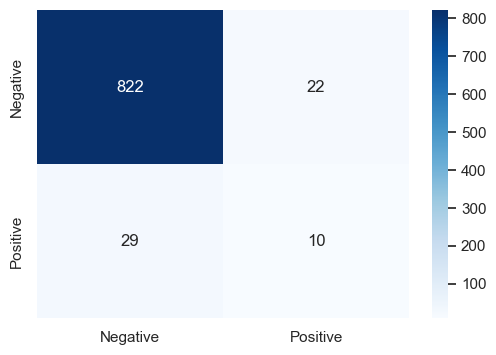

In [56]:
cf_matrix_dt = confusion_matrix(y_test, y_dt_pred)
sns.set(rc={'figure.figsize':(6,4)})

ax = sns.heatmap(cf_matrix_dt, annot = True,cmap='Blues', fmt='g')
ax.set_xticklabels(["Negative", "Positive"])
ax.set_yticklabels(["Negative", "Positive"])
plt.show()

Pada hasil confussion matrix terlihat bahwa:
*   Pada kelas 0 (No) untuk prediksi RainTomorrow pada data test terprediksi benar sebanyak 822 dan 22 terprediksi salah sebagai 1 (Yes)
*   Pada kelas 1 (Yes) untuk prediksi RainTomorrow pada data test terprediksi benar sebanyak 29 dan 10 terprediksi salah sebagai 0 (No)

In [57]:
print(classification_report(y_test, y_dt_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       844
           1       0.31      0.26      0.28        39

    accuracy                           0.94       883
   macro avg       0.64      0.62      0.63       883
weighted avg       0.94      0.94      0.94       883



Tran Model With Tunning
* Decision Tree Train Model

In [58]:
grid_dt = GridSearchCV(pipe_dt, param_dt, cv=5).fit(X_train, y_train)

In [59]:
pipe_dt.fit(X_train, y_train)
print('Training set score: ' + str(grid_dt.score(X_train, y_train)))
print('Test set score: ' + str(grid_dt.score(X_test, y_test)))

Training set score: 0.9648535564853556
Test set score: 0.9558323895809739


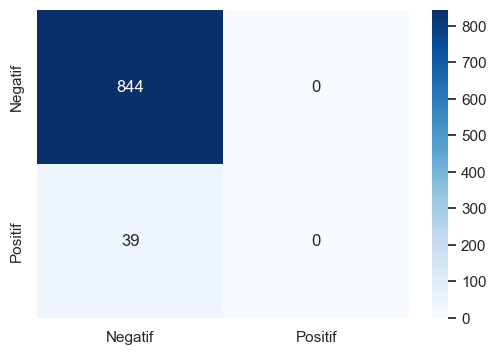

In [60]:
best_pipe_dt = grid_dt.best_estimator_
# Cek confusion matrix
cf_matrix_dt = confusion_matrix(y_test, best_pipe_dt.predict(X_test))

# figure size
sns.set(rc={'figure.figsize':(6,4)})

#plotting confusion matrix
ax = sns.heatmap(cf_matrix_dt, annot=True,cmap='Blues', fmt='g')
ax.set_xticklabels(["Negatif", "Positif"])
ax.set_yticklabels(["Negatif", "Positif"])
plt.show()

Pada hasil confussion matrix terlihat bahwa:
*   Pada kelas 0 (No) untuk prediksi stroke pada data test terprediksi benar sebanyak 844 dan 0 terprediksi salah sebagai 1 (Yes)
*   Pada kelas 1 (Yes) untuk prediksi stroke pada data test terprediksi benar sebanyak 39 dan 0 terprediksi salah sebagai 0 (No)

In [61]:
print(classification_report(y_test, best_pipe_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       844
           1       0.00      0.00      0.00        39

    accuracy                           0.96       883
   macro avg       0.48      0.50      0.49       883
weighted avg       0.91      0.96      0.93       883



c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

* Random Forest Train Model

In [62]:
grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5).fit(X_train, y_train)

In [63]:
pipe_rf.fit(X_train, y_train)
print('Training set score: ' + str(grid_rf.score(X_train, y_train)))
print('Test set score: ' + str(grid_rf.score(X_test, y_test)))

Training set score: 0.9651324965132496
Test set score: 0.9558323895809739


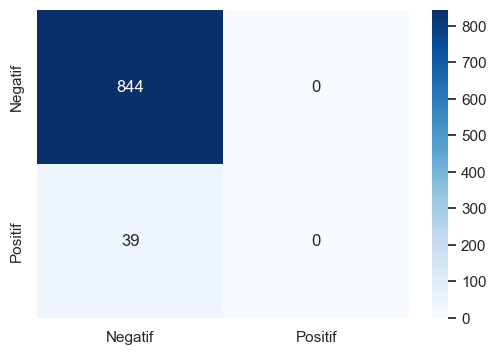

In [66]:
best_pipe_rf = grid_dt.best_estimator_
# Cek confusion matrix
cf_matrix_rf = confusion_matrix(y_test, best_pipe_rf.predict(X_test))

# figure size
sns.set(rc={'figure.figsize':(6,4)})

#plotting confusion matrix
ax = sns.heatmap(cf_matrix_rf, annot=True,cmap='Blues', fmt='g')
ax.set_xticklabels(["Negatif", "Positif"])
ax.set_yticklabels(["Negatif", "Positif"])
plt.show()

Pada hasil confussion matrix terlihat bahwa:
*   Pada kelas 0 (No) untuk prediksi stroke pada data test terprediksi benar sebanyak 844 dan 0 terprediksi salah sebagai 1 (Yes)
*   Pada kelas 1 (Yes) untuk prediksi stroke pada data test terprediksi benar sebanyak 39 dan 0 terprediksi salah sebagai 0 (No)

In [67]:
print(classification_report(y_test, best_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       844
           1       0.00      0.00      0.00        39

    accuracy                           0.96       883
   macro avg       0.48      0.50      0.49       883
weighted avg       0.91      0.96      0.93       883



c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# 4. Model Evaluation

In [68]:
rf_notun = pipe_rf.score(X_test, y_test)
rf_tun = grid_rf.score(X_test, y_test)
dt_notun = pipe_dt.score(X_test, y_test)
dt_tun = grid_dt.score(X_test, y_test)

In [69]:
print(round(rf_notun, 4))
print(round(rf_tun, 4))
print(round(dt_notun, 4))
print(round(dt_tun, 4))

0.957
0.9558
0.9434
0.9558


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6404\1654585409.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= model_acc, y=model_name, palette='magma')


<Axes: >

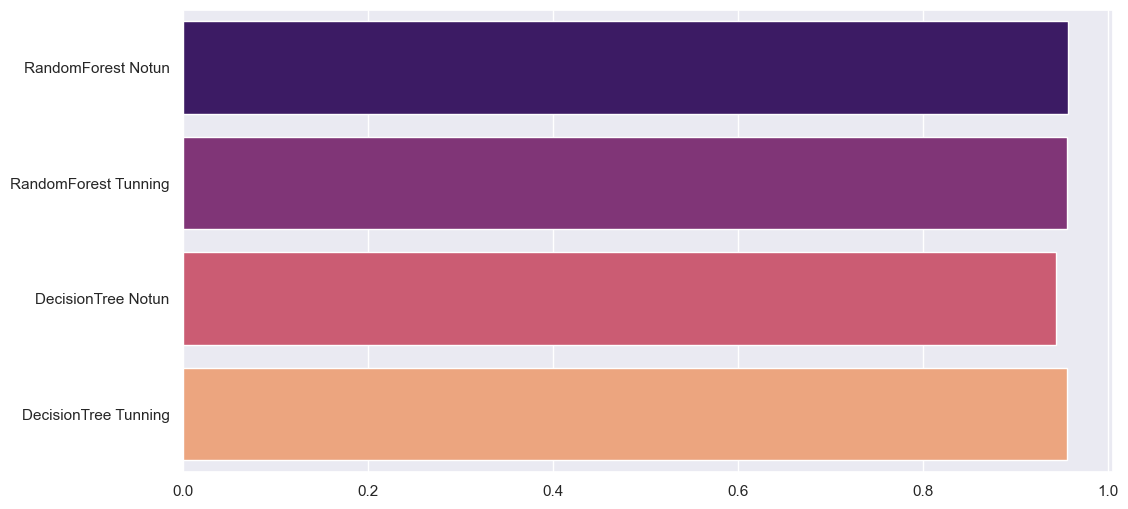

In [70]:
plt.figure(figsize=(12,6))
model_acc = [rf_notun, rf_tun, dt_notun, dt_tun]
model_name = ['RandomForest Notun', 'RandomForest Tunning', 'DecisionTree Notun', 'DecisionTree Tunning']
sns.barplot(x= model_acc, y=model_name, palette='magma')

* Menghitung dan menyimpan skor metrik evaluasi (F1, recall, dan precision) untuk setiap model yang telah dilatih

In [71]:
from sklearn.metrics import f1_score, recall_score, precision_score

models = {
    'rf_notun': pipe_rf,
    'rf_tun': best_pipe_rf,
    'dt_notun': pipe_dt,
    'dt_tun': best_pipe_dt
}
metrics = {
    'f1_score':f1_score,
    'recall':recall_score,
    'precission':precision_score
}

hrt_model = pd.DataFrame(columns=models.keys(), index=['f1_score','recall', 'precission'])

for metric in metrics.keys():
    for model in models.keys():
        hrt_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
